# Differential correlation analysis

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
%matplotlib inline
import itertools

In [2]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq')
import encode
import memento

In [3]:
pd.set_option('display.max_rows', None)

In [4]:
data_path = '/data_volume/memento/hbec/'
fig_path = '/data/home/Github/scrna-parameter-estimation/figures/fig6/'

In [5]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [6]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)

### Get canonical TFs

In [7]:
tf_df = pd.read_csv('human_tf.txt', sep='\t')
tf_list = tf_df['Symbol'].tolist()
tf_list += ['CIITA']

### Read the processed RNA data

Focus on the club and bc/club cells and type I interferons for now.

Encode the timestamps to integers.

In [8]:
# adata_processed = sc.read(data_path + 'HBEC_type_I_processed_deep.h5ad')

In [9]:
adata = sc.read(data_path + 'HBEC_type_I_filtered_counts_deep.h5ad')

In [10]:
adata = adata[:, ~adata.var.index.str.startswith('MT-')].copy()
# adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'basal/club' else 'bc')
# adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'ionocyte/tuft' else 'ion-tuft')

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [11]:
adata.shape

(69958, 36588)

In [12]:
converter = {'basal/club':'BC', 'basal':'B', 'ciliated':'C', 'goblet':'G', 'ionocyte/tuft':'IT', 'neuroendo':'N'}

In [13]:
adata.obs.cell_type.value_counts()

basal/club       29792
basal            22844
ciliated         15041
goblet            1525
ionocyte/tuft      546
neuroendo          210
Name: cell_type, dtype: int64

In [14]:
adata.obs['ct'] = adata.obs['cell_type'].apply(lambda x: converter[x])

### Setup memento

In [15]:
def assign_q(batch):
    
    if batch == 0:
        return 0.387*0.25
    elif batch == 1:
        return 0.392*0.25
    elif batch == 2:
        return 0.436*0.25
    else:
        return 0.417*0.25

In [16]:
adata.obs['q'] = adata.obs['batch'].apply(assign_q)

In [17]:
memento.setup_memento(adata, q_column='q', trim_percent=0.05)

Version 0.0.6


### Read 1d HT result comparing to control

In [18]:
cts = [['ciliated']]
tps = [ '6',]
stims = ['alpha', 'beta', 'gamma', 'lambda']

In [19]:
def read_result(ct):
    
    ht_dict = {}
    moments_dict = {}
    
    for stim in stims:
        ht_dict[stim] = {}
        moments_dict[stim] = {}
        for tp in tps: 
            adata_subset = sc.read(data_path + '/binary_test_latest/{}_{}_{}.h5ad'.format('-'.join(ct), stim, tp))
            ht_dict[stim][tp] = memento.get_1d_ht_result(adata_subset)
            ht_dict[stim][tp]['de_fdr'] = memento.util._fdrcorrect(ht_dict[stim][tp]['de_pval'])
            ht_dict[stim][tp]['dv_fdr'] = memento.util._fdrcorrect(ht_dict[stim][tp]['dv_pval'])
            moments_dict[stim][tp] = memento.get_1d_moments(adata_subset, groupby='time_step')
    return ht_dict,moments_dict

In [20]:
all_result = {}
for ct in cts:
    
    all_result['ht'], all_result['moments'] = read_result(ct)

In [21]:
np.log(1.5)

0.4054651081081644

In [22]:
stims = ['alpha', 'beta', 'gamma', 'lambda']
# ct = 'ciliated'
de_genes  = {}
robust_de_genes = {}
for stim in stims:
    de_genes[stim] = all_result['ht'][stim]['6'].query('de_fdr < 0.1 & de_coef > 0.4054651081081644').gene.tolist() #np.log(1.5)
    robust_de_genes[stim] = all_result['ht'][stim]['6'].query('de_fdr < 0.1 & de_coef > 0.4054651081081644').gene.tolist() #np.log(1.5)

# de_genes['alpha/beta'] = set(de_genes['alpha']) | set(de_genes['beta'])

# stims = ['gamma', 'lambda', 'alpha/beta']
    
uniq_de_genes = {}
for stim in stims:
    
    uniq_de_genes[stim] = set(de_genes[stim])
    for other in stims:
        if stim == other or (stim in ['alpha', 'beta'] and other in ['alpha', 'beta']): continue
        uniq_de_genes[stim] -= set(de_genes[other])
    print(stim, len(uniq_de_genes[stim]))

shared_de_genes = set()
for stim in stims:
    if len(shared_de_genes) == 0:
        shared_de_genes = set(robust_de_genes[stim])
    else:
        shared_de_genes &= set(robust_de_genes[stim])

all_de_genes = set()
for stim in ['alpha', 'beta', 'gamma', 'lambda']:
    all_de_genes |= set(de_genes[stim])
shared_de_genes_lenient = all_de_genes - shared_de_genes
for stim in ['gamma', 'lambda', 'alpha', 'beta']:
    shared_de_genes_lenient -= uniq_de_genes[stim]
print('shared', len(shared_de_genes))
print('partial', len(shared_de_genes_lenient))

alpha 353
beta 458
gamma 69
lambda 40
shared 165
partial 271


### Run differential correlation between STAT1 and each stim's DEGs

In [29]:
ct = ['ciliated']
all_stims = ['gamma', 'lambda', 'alpha', 'beta']

In [24]:
# for stim in all_stims:
    
#     print('starting ', stim, '....')

#     adata_stim = adata.copy()[
#         adata.obs.cell_type.isin(ct) & \
#         adata.obs.stim.isin(['control', stim])].copy()
    
#     # time_converter={0:0, int('6'):1}
#     adata_stim.obs['time_step'] = adata_stim.obs['time']#.astype(int).apply(lambda x: time_converter[x])
#     adata_stim.obs['time'] = 'tp_' + adata_stim.obs['time'].astype(str)

#     memento.create_groups(adata_stim, label_columns=['time', 'donor'])
#     memento.compute_1d_moments(adata_stim, min_perc_group=.3)
#     moment_1d_df = memento.get_1d_moments(adata_stim, groupby='time')

# #     available_tfs = list(set(tf_list) & set(moment_1d_df[0].gene))
#     available_targets = list(set(de_genes[stim if stim not in ['alpha', 'beta'] else 'alpha/beta']) & set(moment_1d_df[0].gene))

#     memento.compute_2d_moments(adata_stim, list(itertools.product(['STAT1'], available_targets)))

# #     moment_df = memento.get_2d_moments(adata_stim, groupby='time') 

# #     moment_df['max_corr'] = moment_df.iloc[:, 2:].max(axis=1).values

# #     candidates = moment_df.query('max_corr > 0.3 & gene_1 != gene_2')

# # #     top_tfs = candidates.groupby('gene_1').size().sort_values(ascending=False)
# # #     top_tfs = top_tfs[top_tfs > 15].index.tolist()

# # #     candidates = candidates.query('gene_1 in @top_tfs')

# #     candidates = list(zip(candidates['gene_1'], candidates['gene_2']))

# #     memento.compute_2d_moments(adata_stim, candidates)

#     memento.ht_2d_moments( 
#         adata_stim, 
#         formula_like='1 + time + donor',
#         treatment_col='time', 
#         num_boot=10000, 
#         verbose=1,
#         num_cpus=94,
#         resampling='permutation',
#         approx=False)
    
#     adata_stim.write(data_path + 'stat1_coex_test/{}.h5ad'.format(stim))


In [25]:
for stim in all_stims:
        
    print('starting ', stim, '....')

    adata_stim = adata.copy()[
        adata.obs.time.isin(['0', '6']) &\
        adata.obs.cell_type.isin(ct) & \
        adata.obs.stim.isin(['control', stim])].copy()
    
#     time_converter={'0':0, '3':1, '6':2, '9':3, '24':4, '48':5}
    adata_stim.obs['time_step'] = adata_stim.obs['time']#.astype(int).apply(lambda x: time_converter[x])
    adata_stim.obs['time'] = 'tp_' + adata_stim.obs['time'].astype(str)#.apply(lambda x: time_converter[x])
    adata_stim.obs['is_stim'] = (adata_stim.obs.stim==stim).astype(int)

    memento.create_groups(adata_stim, label_columns=['is_stim', 'donor'])
    memento.compute_1d_moments(adata_stim, min_perc_group=.9)
    moment_1d_df = memento.get_1d_moments(adata_stim, groupby='is_stim')

    available_targets = list(set(de_genes[stim]) & set(moment_1d_df[0].gene))

    memento.compute_2d_moments(adata_stim, list(itertools.product(['STAT1'], available_targets)))

    moment_df = memento.get_2d_moments(adata_stim, groupby='is_stim') 

#     moment_df['max_corr'] = moment_df.iloc[:, 2:].max(axis=1).values

#     candidates = moment_df.query('max_corr > 0.3 & gene_1 != gene_2')

#     candidates = list(zip(candidates['gene_1'], candidates['gene_2']))

#     memento.compute_2d_moments(adata_stim, candidates)
    
    memento.ht_2d_moments( 
        adata_stim, 
        formula_like='1 + is_stim + donor',
        treatment_col='is_stim', 
        num_boot=10000, 
        verbose=1,
        num_cpus=94,
        resampling='permutation',
        approx=False)
    
    adata_stim.write(data_path + 'stat1_coex_test/{}_6hr.h5ad'.format(stim))


starting  gamma ....


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    7.1s
[Parallel(n_jobs=94)]: Done 262 tasks      | elapsed:   17.7s
[Parallel(n_jobs=94)]: Done 459 out of 459 | elapsed:   27.6s finished
... storing 'time' as categorical
... storing 'memento_group' as categorical


starting  lambda ....


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    2.0s
[Parallel(n_jobs=94)]: Done 288 out of 288 | elapsed:    9.9s finished
... storing 'time' as categorical
... storing 'memento_group' as categorical


starting  alpha ....


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    3.0s
[Parallel(n_jobs=94)]: Done 262 tasks      | elapsed:   13.2s
[Parallel(n_jobs=94)]: Done 714 out of 714 | elapsed:   33.0s finished
... storing 'time' as categorical
... storing 'memento_group' as categorical


starting  beta ....


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    4.1s
[Parallel(n_jobs=94)]: Done 262 tasks      | elapsed:   18.8s
[Parallel(n_jobs=94)]: Done 612 tasks      | elapsed:   41.0s
[Parallel(n_jobs=94)]: Done 862 out of 862 | elapsed:   55.4s finished
... storing 'time' as categorical
... storing 'memento_group' as categorical


### Get binding sites

In [23]:
enc = encode.Encode('/home/ssm-user/Github/misc-seq/miscseq/GRCh38Genes.bed')

In [24]:
stat1_bed = enc.get_encode_peaks_union([
    'https://www.encodeproject.org/files/ENCFF747ICD/@@download/ENCFF747ICD.bed.gz',
    'https://www.encodeproject.org/files/ENCFF646MXG/@@download/ENCFF646MXG.bed.gz'
])
stat2_bed = enc.get_encode_peaks_union([
    'https://www.encodeproject.org/files/ENCFF204VQS/@@download/ENCFF204VQS.bed.gz',
    'https://www.encodeproject.org/files/ENCFF545JVD/@@download/ENCFF545JVD.bed.gz'
])

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python

In [25]:
intersect_bed = stat1_bed.intersect(stat2_bed).sort()

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)


In [26]:
isgf3_genes = enc.get_peak_genes_bed(intersect_bed, 0).query('distance == 0 & ~gene.str.contains("MT").values').gene.tolist()
stat1_genes = enc.get_peak_genes_bed(stat1_bed, 0).query('distance == 0 & ~gene.str.contains("MT").values').gene.tolist()

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pybedtools/bedtool.py:3678: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file 

### Read DC results

In [30]:
def classify(x):
    
    if x in shared_de_genes:
        return 'shared'
    elif x in shared_de_genes_lenient:
        return 'partially_shared'
    for stim in stims:
        if x in uniq_de_genes[stim]:
            return 'uniq_' + stim
    return 'none-DE'

In [31]:
deg_dc_results = {}
deg_2d_moments = {}
deg_m_moments = {}
deg_v_moments = {}
combined_results = {}

for stim in all_stims:
    
    adata_stim = sc.read(data_path + 'stat1_coex_test/{}_6hr.h5ad'.format(stim))
    deg_dc_results[stim] = memento.get_2d_ht_result(adata_stim)
    deg_2d_moments[stim] = memento.get_2d_moments(adata_stim, groupby='is_stim')#[['gene_1','gene_2'] + ['time_'+str(i) for i in [0, 1, 2, 3, 4, 5]]]
#     deg_m_moments[stim],deg_v_moments[stim] = memento.get_1d_moments(adata_stim, groupby='time')
#     deg_m_moments[stim] = deg_m_moments[stim][['gene'] + ['time_'+str(i) for i in [0, 3, 6, 9, 24, 48]]]
#     deg_v_moments[stim] = deg_v_moments[stim][['gene'] + ['time_'+str(i) for i in [0, 3, 6, 9, 24, 48]]]
    deg_dc_results[stim]['corr_fdr'] = memento.util._fdrcorrect(deg_dc_results[stim]['corr_pval'])
    
    combined_results[stim] = deg_2d_moments[stim].merge(deg_dc_results[stim], on=['gene_1', 'gene_2'])
    combined_results[stim]['deg_type'] = combined_results[stim]['gene_2'].apply(classify)
    combined_results[stim]['sig'] =  \
        (combined_results[stim]['corr_fdr'] < 0.15)# & ((combined_results[stim]['is_stim_1'] >0.3) | (combined_results[stim]['is_stim_0'] >0.3))
    combined_results[stim]['stim'] = stim
    combined_results[stim]['isgf3_tss'] = combined_results[stim]['gene_2'].isin(isgf3_genes)
    combined_results[stim]['stat1_tss'] = combined_results[stim]['gene_2'].isin(stat1_genes)

combined_result = pd.concat([combined_results[stim] for stim in all_stims])
combined_result['shared'] = combined_result['deg_type'] == 'shared'
combined_result['always_high'] = (combined_result['is_stim_0'] > 0.3) & (combined_result['is_stim_1'] > 0.3)

    
   

### Correlations and TSS presence

In [70]:
# a = combined_result[['stat1_tss', 'is_stim_0', 'stim']].rename(columns={'is_stim_0':'corr'})
b = combined_result[['stat1_tss', 'is_stim_1', 'stim', 'shared']].rename(columns={'is_stim_1':'corr'})
a = combined_result.query('stim=="gamma"')[['stat1_tss', 'is_stim_0', 'stim', 'shared']].rename(columns={'is_stim_0':'corr'})
a['stim'] = 'control'

c = pd.concat([a,b])

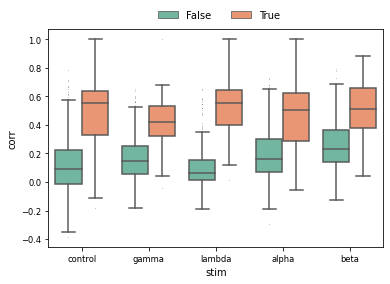

In [69]:
sns.boxplot(x='stim', y='corr', hue='stat1_tss',data=c, palette='Set2', fliersize=0.1);
plt.legend(bbox_to_anchor=(0.3, 1), frameon=False, ncol=2)

In [32]:
for stim in all_stims:
    
    print(combined_result.query('stim=="{}" & sig'.format(stim)).shape)
    
    a = combined_result.query('stim=="{}"'.format(stim))
    contingency = pd.crosstab(
        a['sig'], 
        a['stat1_tss'])
    print(stim)
    print(contingency)
    print(stim, stats.fisher_exact(contingency))

(176, 15)
gamma
stat1_tss  False  True 
sig                    
False        251     33
True         151     25
gamma (1.2592815572948024, 0.47040268088460613)
(2, 15)
lambda
stat1_tss  False  True 
sig                    
False        233     54
True           2      0
lambda (0.0, 1.0)
(230, 15)
alpha
stat1_tss  False  True 
sig                    
False        426     59
True         198     32
alpha (1.1669234720082178, 0.5484730271815097)
(557, 15)
beta
stat1_tss  False  True 
sig                    
False        277     29
True         489     68
beta (1.3282561173401028, 0.2601372752646759)


In [51]:
stats.mannwhitneyu(combined_result.query('stim == "beta" & stat1_tss').corr_coef,
combined_result.query('stim == "beta" & ~stat1_tss').corr_coef)

MannwhitneyuResult(statistic=32092.0, pvalue=0.01437007258217829)

Text(0, 0.5, '')

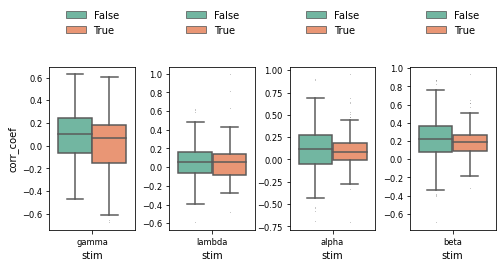

In [85]:
a = combined_result.sort_values('deg_type')

plt.figure(figsize=(8, 3))
plt.subplots_adjust(wspace=0.4)
plt.subplot(1, 4, 1)
sns.boxplot(y='corr_coef', x='stim', hue='shared', data=a.query('stim=="gamma"'), fliersize=0.1, palette='Set2')
plt.legend(ncol=1,frameon=False, loc='upper center', bbox_to_anchor=(0.5,1.4))

plt.subplot(1, 4, 2)
sns.boxplot(y='corr_coef', x='stim', hue='shared', data=a.query('stim=="lambda"'), fliersize=0.1, palette='Set2')
plt.legend(ncol=1,frameon=False, loc='upper center', bbox_to_anchor=(0.5,1.4)); plt.ylabel(None)

plt.subplot(1, 4, 3)
sns.boxplot(y='corr_coef', x='stim', hue='shared', data=a.query('stim=="alpha"'), fliersize=0.1, palette='Set2')
plt.legend(ncol=1,frameon=False, loc='upper center', bbox_to_anchor=(0.5,1.4)); plt.ylabel(None)

plt.subplot(1, 4, 4)
sns.boxplot(y='corr_coef', x='stim', hue='shared', data=a.query('stim=="beta"'), fliersize=0.1, palette='Set2')
plt.legend(ncol=1,frameon=False, loc='upper center', bbox_to_anchor=(0.5,1.4)); plt.ylabel(None)

<AxesSubplot:xlabel='stim', ylabel='corr_coef'>

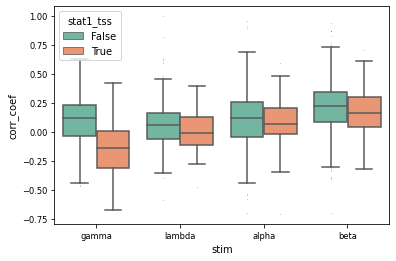

In [52]:
sns.boxplot(y='corr_coef', x='stim', hue='stat1_tss', data=combined_result, fliersize=0.1, palette='Set2')

In [53]:
ht_2d_df = memento.get_2d_ht_result(adata_stim)
ht_2d_df['corr_fdr'] = memento.util._fdrcorrect(ht_2d_df['corr_pval'])
sig_df = ht_2d_df.query('corr_fdr < 0.1')

In [54]:
tp_order = ['time_tp_' + str(i) for i in [0, 3, 6, 9, 24, 48]]

In [55]:
moment_1d_df[0].query('gene == "CIITA"')[tp_order]

KeyError: "None of [Index(['time_tp_0', 'time_tp_3', 'time_tp_6', 'time_tp_9', 'time_tp_24',\n       'time_tp_48'],\n      dtype='object')] are in the [columns]"

In [85]:
dra=moment_df.merge(sig_df[['gene_1', 'gene_2']], on=['gene_1', 'gene_2'], how='inner')\
    .query('gene_2.str.startswith("HLA-DRA")', engine='python')[['gene_1', 'gene_2'] + tp_order]

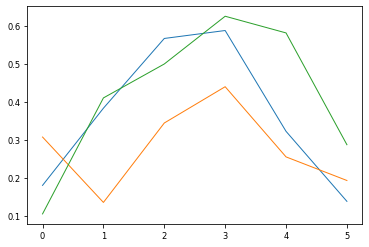

In [86]:
plt.plot(dra[tp_order].values.T, lw=1);